In [1]:
#Import standard packages for model training

import tensorflow as T
from tensorflow import *
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.losses import *
import numpy as np
import pandas as pd
import sklearn.metrics as SK
from sklearn.metrics import *
import matplotlib.pyplot as plt
import os 
import io
from utils import utils
from utils.GPU import *
commons = utils.Commons()
ts_helper = utils.TS_Helper()
ts_helper.model_type = ts_helper.Classification
shap_helper = utils.Shap_Helper()
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

  tensorlayer: GPU MEM Fraction 0.900000
Num GPUs Available:  0


In [2]:
#Import train, validation and test sets

training = './data/Classification/T.cruzi/scaffold_split/train_fold_0.csv'
validation = './data/Classification/T.cruzi/scaffold_split/valid_fold_1.csv'
test = './data/Classification/T.cruzi/scaffold_split/test_fold_2.csv'
TASK_START = 2
NUM_TASKS = 1
SMILES = "SMILES"
train_dataset,y_train,train_smiles = commons.load_dataset(training,SMILES,TASK_START,NUM_TASKS)
val_dataset,y_val,val_smiles = commons.load_dataset(validation,SMILES,TASK_START,NUM_TASKS)
test_dataset,y_test,test_smiles = commons.load_dataset(test,SMILES,TASK_START,NUM_TASKS)

#train_dataset.iloc[:,TASK_START] = list(map(lambda x: float(x), train_dataset.iloc[:,TASK_START]))
#y_train = list(map(lambda x: float(x), y_train))

#test_dataset.iloc[:,TASK_START] = list(map(lambda x: float(x), test_dataset.iloc[:,TASK_START]))
#y_test = list(map(lambda x: float(x), y_test))
#val_dataset.iloc[:,TASK_START].astype(float)
#val_dataset.iloc[:,TASK_START] = [float(x) for x in val_dataset.iloc[:,TASK_START]]
#y_val = [float(y) for y in y_val]


Loaded dataset ./data/Classification/T.cruzi/scaffold_split/train_fold_0.csv with shape: (4914, 3)
Loaded dataset ./data/Classification/T.cruzi/scaffold_split/valid_fold_1.csv with shape: (615, 3)
Loaded dataset ./data/Classification/T.cruzi/scaffold_split/test_fold_2.csv with shape: (614, 3)


In [3]:
#Import atom and bond featurizers

from utils.graphs import *

X_train = graphs_from_smiles(train_dataset.iloc[:,NUM_TASKS].values)
#print(train_dataset.iloc[:,NUM_TASKS].values)
X_test = graphs_from_smiles(test_dataset.iloc[:,NUM_TASKS].values)

X_val = graphs_from_smiles(val_dataset.iloc[:,NUM_TASKS].values)
 
#molecule = molecule_from_smiles(train_dataset.iloc[8].SMILES)
#graph = graph_from_molecule(molecule)
# print("Graph (including self-loops):")
# print("\tatom features\t", graph[0].shape)
# print("\tbond features\t", graph[1].shape)
# print("\tpair indices\t", graph[2].shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 atom_features (InputLayer)     [(None, 29)]         0           []                               
                                                                                                  
 bond_features (InputLayer)     [(None, 7)]          0           []                               
                                                                                                  
 pair_indices (InputLayer)      [(None, 2)]          0           []                               
                                                                                                  
 message_passing (MessagePassin  (None, 48)          32544       ['atom_features[0][0]',          
 g)                                                               'bond_features[0][0]',      

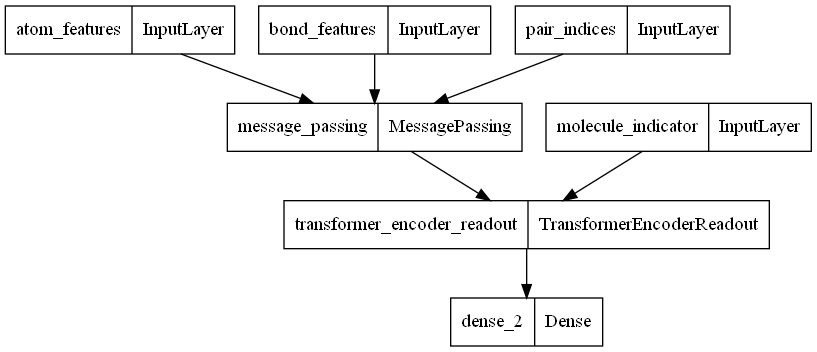

In [4]:
# Import parameters for batch, MPNN, loss and scorers

batch_size =48
dense_units = 50

from utils.batch import *
from utils.MPNN import *
from utils.utils import *


# parameters for train network

def MPNNModel(atom_dim,
    bond_dim,
    batch_size=batch_size,
    message_units=48,
    message_steps=8,
    num_attention_heads=16,
    dense_units=dense_units):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)([atom_features, bond_features, pair_indices])
    x = TransformerEncoderReadout(num_attention_heads, message_units, dense_units, batch_size)([x, molecule_indicator])
    x = layers.Dense(10, activation="sigmoid", kernel_regularizer=T.keras.regularizers.L2(0.05))(x)

    
    model = keras.Model(inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x])
    return model
    
optimizer = RMSprop(0.1, momentum=0.99)
lr_metric = ts_helper.get_lr_metric(optimizer)   

model = MPNNModel(atom_dim=X_train[0][0][0].shape[0], bond_dim=X_train[1][0][0].shape[0])
model.compile(loss = ts_helper.classification_loss(ts_helper.BinaryCrossentropy,1), metrics=[lr_metric])   
model.summary()
T.keras.utils.plot_model(model)

In [6]:
# Early stopping parameters

train_model = MPNNDataset(X_train, y_train, batch_size)
val_model = MPNNDataset(X_val, y_val, batch_size)
test_model = MPNNDataset(X_test, y_test, batch_size)
#print(train_dataset.unbatch())
callbacks_list = [
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=0.000000001, verbose=1, mode='auto',cooldown=0),
    #ModelCheckpoint(filepath="./models/fine_tuned_model2.tf", monitor='val_loss', save_best_only=True, verbose=1, mode='auto'),
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', verbose=1)]

# parameters for train network

epochs = 20

history = model.fit(train_model,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_data = val_model,                    
                    callbacks = (callbacks_list))


Epoch 1/20
103/103 [==============================] - 53s 515ms/step - loss: 0.0070 - lr: 0.0010 - val_loss: 0.0067 - val_lr: 0.1000
Epoch 2/20
103/103 [==============================] - 53s 512ms/step - loss: 0.0064 - lr: 0.0010 - val_loss: 0.0061 - val_lr: 0.1000
Epoch 3/20
103/103 [==============================] - 53s 512ms/step - loss: 0.0059 - lr: 0.0010 - val_loss: 0.0057 - val_lr: 0.1000
Epoch 4/20
103/103 [==============================] - 53s 514ms/step - loss: 0.0055 - lr: 0.0010 - val_loss: 0.0053 - val_lr: 0.1000
Epoch 5/20
103/103 [==============================] - 54s 519ms/step - loss: 0.0051 - lr: 0.0010 - val_loss: 0.0049 - val_lr: 0.1000
Epoch 6/20
103/103 [==============================] - 53s 516ms/step - loss: 0.0047 - lr: 0.0010 - val_loss: 0.0045 - val_lr: 0.1000
Epoch 7/20
103/103 [==============================] - 53s 512ms/step - loss: 0.0044 - lr: 0.0010 - val_loss: 0.0042 - val_lr: 0.1000
Epoch 8/20
103/103 [==============================] - 53s 516ms/step 

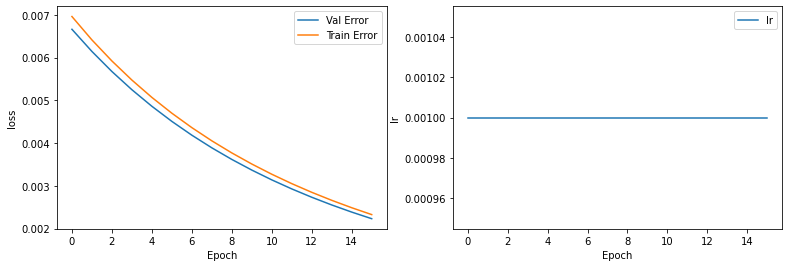

In [7]:
#Plot model history

ts_helper.plot_history(history)



0
Metric for a Classification Model
103/103 [==============================] - 25s 237ms/step
      pred  y
0      0.0  1
1      0.0  0
2      0.0  1
3      0.0  0
4      0.0  1
...    ... ..
4909   0.0  0
4910   0.0  0
4911   0.0  0
4912   0.0  0
4913   0.0  0

[4914 rows x 2 columns]
13/13 [==============================] - 3s 241ms/step
     pred  y
0     0.0  1
1     0.0  0
2     0.0  0
3     0.0  1
4     0.0  0
..    ... ..
610   0.0  0
611   0.0  0
612   0.0  0
613   0.0  0
614   0.0  0

[615 rows x 2 columns]
13/13 [==============================] - 3s 233ms/step
     pred  y
0     0.0  0
1     0.0  0
2     0.0  1
3     0.0  0
4     0.0  0
..    ... ..
609   0.0  0
610   0.0  0
611   0.0  0
612   0.0  0
613   0.0  0

[614 rows x 2 columns]
Confusion matrix: [[3643 1271]
 [   0    0]]
Confusion matrix: [[461 154]
 [  0   0]]
Confusion matrix: [[460 154]
 [  0   0]]
For Training in task 0 
 Statistic         Value
-----------  ----------
Accuracy       0.741351
Precision      0
Re

c:\Users\Laplace\Desktop\work\projetos academicos\labmol\Code_dump\Github_Artigo\Github_Artigo\utils\utils.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
c:\Users\Laplace\Desktop\work\projetos academicos\labmol\Code_dump\Github_Artigo\Github_Artigo\utils\utils.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  SE = (TP/(TP+FN))
c:\Users\Laplace\Desktop\work\projetos academicos\labmol\Code_dump\Github_Artigo\Github_Artigo\utils\utils.py:303: RuntimeWarning: invalid value encountered in longlong_scalars
  TPR = (TP/(TP+FN))
c:\Users\Laplace\Desktop\work\projetos academicos\labmol\Code_dump\Github_Artigo\Github_Artigo\utils\utils.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
c:\Users\Laplace\Desktop\work\projetos academicos\labmol\Code_dump\Github_Artigo\Github_Artigo\utils\utils.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  SE = (TP/(TP+FN))
c:

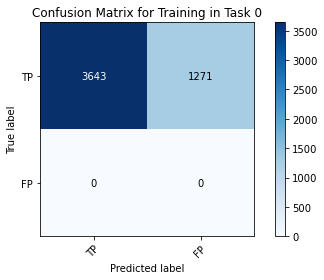

[[461 154]
 [  0   0]]


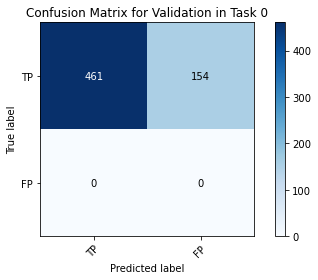

[[460 154]
 [  0   0]]


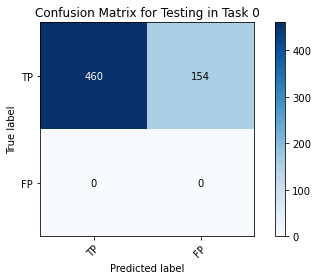

In [8]:
#Statistical characteristics of tasks
THRESHOLD = 0.5
print(ts_helper.model_type)

ts_helper.get_DLmodelStats(model,X_train=train_model,y_train=y_train,X_test=test_model,y_test=y_test,X_val=val_model,y_val=y_val,tasks=NUM_TASKS,threshold=THRESHOLD)